In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tpot import TPOTRegressor


C:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


## Loading all literature data
 This dataset has 4 repeat entries that were not discovered until after all experiments were done. This original
 data file is kept to account for current model used

In [4]:
data = pd.read_csv('all_data_noCB.csv')
groups = data['id']
y = data['dm']

X = data.iloc[:, 2:-2]
y = np.log10(y)

 Initialized kfolds and running TPOT to export an optimized ML pipeline (this section is not needed to run this script)

In [ ]:
cv = GroupKFold()
tpot_m = TPOTRegressor(generations=50, cv = cv, verbosity=2, n_jobs=8, scoring = 'r2')
tpot_m.fit(X[groups < 100], y[groups < 100], groups=groups[groups < 100])
tpot_m.export('new_pipeline_out.py')


## Taking Exported Pipeline and Evaluating Performance

In [5]:
## copied from pipe.py file; this is the final ML model that was used ##
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

np.random.seed(1)

# Average CV score on the training set was: 0.7685271642175507
tpot = make_pipeline(
    make_union(
        StackingEstimator(estimator=make_pipeline(
            StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99, learning_rate=0.1, loss="huber", max_depth=10, max_features=0.7000000000000001, min_samples_leaf=17, min_samples_split=19, n_estimators=100, subsample=0.9000000000000001)),
            SelectFwe(score_func=f_regression, alpha=0.043000000000000003),
            RandomForestRegressor(bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
        )),
        FunctionTransformer(copy)
    ),
    ElasticNetCV(l1_ratio=0.9500000000000001, tol=0.1)
)
###################################

tpot.fit(X[groups < 100], y[groups < 100])  # fitted on training data

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('stackingestimator',
                                                 StackingEstimator(estimator=Pipeline(steps=[('stackingestimator',
                                                                                              StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99,
                                                                                                                                                    loss='huber',
                                                                                                                                                    max_depth=10,
                                                                                                                                                    max_features=0.7000000000000001,
                                                                                                                     

In [6]:
print('r2 score on the test set: ', tpot.score(X[groups >= 100], y[groups >= 100]))
print('mean absolute error of log10(m/A) the test set: ', mean_absolute_error(y[groups >= 100], tpot.predict(X[groups >= 100])))
print('mean squared error of log10(m/A) the test set: ', mean_squared_error(y[groups >= 100], tpot.predict(X[groups >= 100])))

r2 score on the test set:  0.8037134321793481
mean absolute error of log10(m/A) the test set:  0.33642798090487025
mean squared error of log10(m/A) the test set:  0.21050321062469848


## Plotting Parity Plot

In [20]:
def get_colors(values, cmap_in, log=False):
    min_v = values.min()
    max_v = values.max()
    
    if log:
        norm_c = mpl.colors.LogNorm(vmin=min_v,vmax=max_v)
    else:
        norm_c = mpl.colors.Normalize(vmin=min_v,vmax=max_v)
    
    cmap_c = mpl.cm.get_cmap(cmap_in)
    colors = {}
    
    for value in values.values:
        color = cmap_c(norm_c(value[0]))
        colors[str(value[0])] = color
    
    return colors, cmap_c, norm_c

def get_size(values:list, s_min, s_max):
    s_range = np.linspace(s_min, s_max, num=len(values), endpoint=True)
    sizes = {}
    for num in range(len(values)):
        sizes[str(values[num])] = s_range[num]
    
    return sizes



### adding experimental data

In [39]:
new_alloys_pred_oxg= np.array([0.63, 0.46, 0.72, 1.87, 0.95, 0.63, 0.63, 1.87, 0.95])
new_alloys_results_oxg = np.array([1.35, 1.29, 1.51, 1.32, 199.31, 1.47, 2.08, 0.18, 152.35])

new_alloys_pred_oxg_TGA_set = np.array([0.63, 0.63, 0.46, 0.72, 1.87])
new_alloys_results_TGA = np.array([0.6137, 0.7474, 0.2457, 0.5229, 0.7552])

new_alloys_pred_oxp= np.array([5.09, 6.22, 5.09, 6.22, 6.22])
new_alloys_results_oxp = np.array([8.53, 290.84, 4.52, 186.40, 192.13])

### plotting figure

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


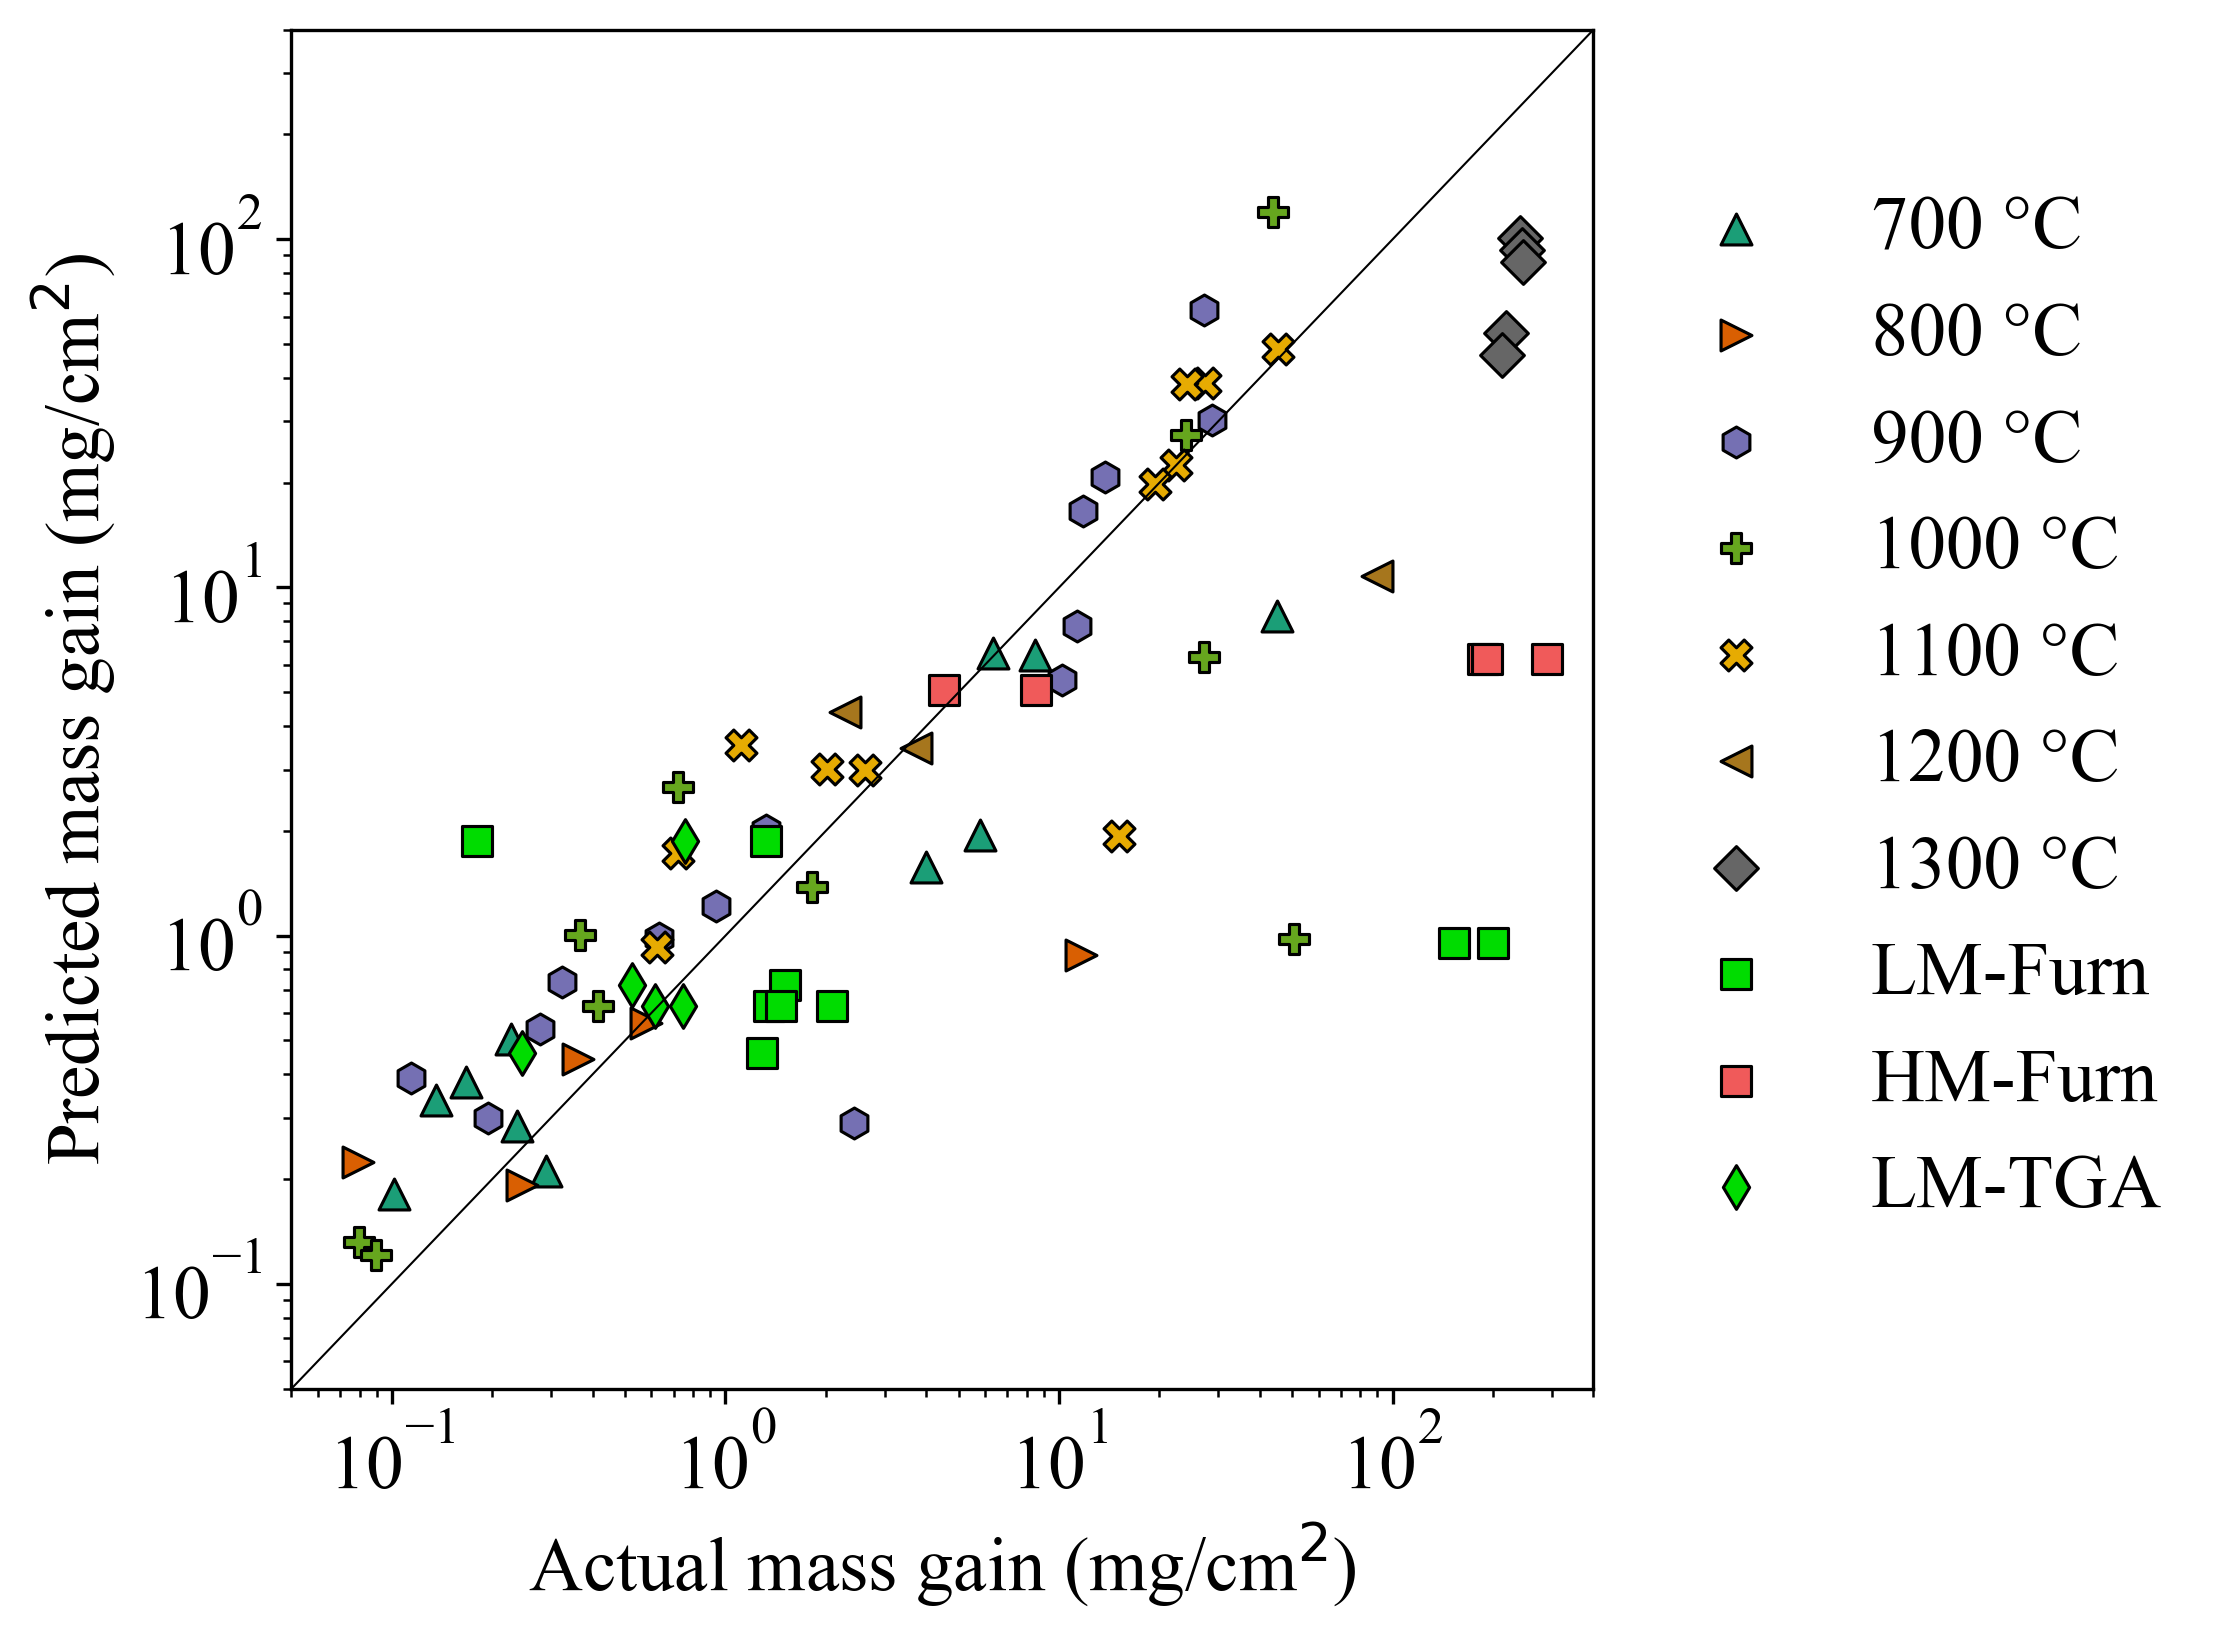

In [52]:
# screen out test data temperatures to label with different colors
data_temps = X[groups >= 100].iloc[:, 0]
temps_used = data_temps.unique()
temps_used.sort()

temps_dict = {}
for temp in temps_used:
    temps_dict[temp]=data_temps.index[data_temps==temp].tolist()

results = pd.DataFrame(tpot.predict(X[groups >= 100]), index=list(data_temps.index))

fig, ax = plt.subplots()
mark_s = 55
deg_symb = u'\N{DEGREE SIGN}'


colors_mg, cmap_mg, norm_mg = get_colors(pd.DataFrame(temps_used), 'Dark2', log=False)
size_mg = get_size(list(temps_used), 20, 60)

mshapes = {'700': '^',
           '800': '>',
           '900': 'h',
           '1000': 'P',
           '1100': 'X',
           '1200': '<',
           '1300': 'D'}

for temp in temps_used:
    index_temp = temps_dict[temp]
    act_vals = 10**y[groups >= 100][index_temp]
    pred_vals = 10**results.loc[index_temp]
#     mark_s = size_mg[str(temp)]
    curr_mshape = mshapes[str(temp)]
#     curr_mshape = 'o'
    ax.scatter(act_vals, pred_vals, c=np.array([colors_mg[str(temp)]]), marker=curr_mshape,
               linewidths=0.75, edgecolors='k', label=str(temp)+' '+deg_symb+'C', s=mark_s)
    
lmc = (0/255, 220/255, 0/255, 1)
hmc = (240/255, 90/255, 90/255, 1)
m_exp_s = 55
ax.scatter(new_alloys_results_oxg, new_alloys_pred_oxg, marker='s', 
            linewidths=0.75, edgecolors='k', c=lmc, label="LM-Furn", s=m_exp_s)
ax.scatter(new_alloys_results_oxp, new_alloys_pred_oxp, marker='s', 
            linewidths=0.75, edgecolors='k', c=hmc, label="HM-Furn", s=m_exp_s)

ax.scatter(new_alloys_results_TGA, new_alloys_pred_oxg_TGA_set, marker='d', 
            linewidths=0.75, edgecolors='k', c=lmc, label="LM-TGA", s=m_exp_s)
    
up_lim = 400
lo_lim = 0.05
plt.plot(np.linspace(lo_lim, up_lim), np.linspace(lo_lim, up_lim), c='k', linewidth=.5)
plt.xlabel('Actual mass gain (mg/cm$^2$)')
plt.ylabel('Predicted mass gain (mg/cm$^2$)')
ax.set_ylim(lo_lim, up_lim)
ax.set_xlim(lo_lim, up_lim)
ax.set_yscale('log')
ax.set_xscale('log')

fig.set_size_inches(7, 6)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(edgecolor='w', loc='center left', bbox_to_anchor=(1, 0.5))

plt.rcParams.update({'font.size': 18, 'font.family':'Times New Roman', 'figure.dpi': 300})

plt.show()

## New Predictions with Model

In [8]:
###################################
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

np.random.seed(1)

new_preds_tpot = make_pipeline(
    make_union(
        StackingEstimator(estimator=make_pipeline(
            StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99, learning_rate=0.1, loss="huber", max_depth=10, max_features=0.7000000000000001, min_samples_leaf=17, min_samples_split=19, n_estimators=100, subsample=0.9000000000000001)),
            SelectFwe(score_func=f_regression, alpha=0.043000000000000003),
            RandomForestRegressor(bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
        )),
        FunctionTransformer(copy)
    ),
    ElasticNetCV(l1_ratio=0.9500000000000001, tol=0.1)
)
###################################

new_preds_tpot.fit(X,y) # fitted on all the data, training and test sets

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('stackingestimator',
                                                 StackingEstimator(estimator=Pipeline(steps=[('stackingestimator',
                                                                                              StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99,
                                                                                                                                                    loss='huber',
                                                                                                                                                    max_depth=10,
                                                                                                                                                    max_features=0.7000000000000001,
                                                                                                                     

In [24]:
new_entry_composition = [[1000, 0, 25, 0, 25, 0, 0, 0, 0, 25, 25, 0, 0, 0, 0, 0, 0]]
new_entry = pd.DataFrame(new_entry_composition, columns=list(X))
print(new_entry)
print("\nmass change value: ", 10**new_preds_tpot.predict(new_entry))

      T  Mo  Ni  W  Al  Cr  Ti  Si  Cu  Fe  Co  Mn  V  Zr  Hf  Ta  Nb
0  1000   0  25  0  25   0   0   0   0  25  25   0  0   0   0   0   0

mass change value:  [0.31136762]
